## Importing Libraries

In [22]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler  
from sklearn.metrics import plot_roc_curve, confusion_matrix, roc_auc_score, classification_report, average_precision_score, plot_precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

In [2]:
date_columns = ["Timestamp"]
df = pd.read_csv("ddos_dataset.csv", parse_dates=date_columns,index_col=None)
df.head()

,Flow ID,Timestamp,Fwd Pkt Len Mean,Fwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label
0,172.31.69.28-18.216.200.189-80-52169-6,2018-02-22 00:27:57,233.750000,233.750000,-1,32768,0,ddos
1,172.31.69.25-18.219.193.20-80-44588-6,2018-02-16 23:18:14,0.000000,0.000000,-1,225,0,ddos
2,172.31.69.25-18.219.193.20-80-43832-6,2018-02-16 23:23:20,114.333333,114.333333,-1,219,0,ddos
3,172.31.69.25-18.219.193.20-80-53346-6,2018-02-16 23:22:41,233.750000,233.750000,-1,211,0,ddos
4,172.31.69.28-18.218.55.126-80-57856-6,2018-02-21 23:49:25,233.750000,233.750000,-1,32768,0,ddos


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Flow ID            500000 non-null  object        
 1   Timestamp          500000 non-null  datetime64[ns]
 2   Fwd Pkt Len Mean   500000 non-null  float64       
 3   Fwd Seg Size Avg   500000 non-null  float64       
 4   Init Fwd Win Byts  500000 non-null  int64         
 5   Init Bwd Win Byts  500000 non-null  int64         
 6   Fwd Seg Size Min   500000 non-null  int64         
 7   Label              500000 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 30.5+ MB


## Feature Extraction from `Flow ID` column

In [4]:
df[['Source', 'Destination', 'Source Port', 'Dest Port', 'Other']] = df['Flow ID'].str.split('-', expand=True)
df.head()

,Flow ID,Timestamp,Fwd Pkt Len Mean,Fwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label,Source,Destination,Source Port,Dest Port,Other
0,172.31.69.28-18.216.200.189-80-52169-6,2018-02-22 00:27:57,233.750000,233.750000,-1,32768,0,ddos,172.31.69.28,18.216.200.189,80,52169,6
1,172.31.69.25-18.219.193.20-80-44588-6,2018-02-16 23:18:14,0.000000,0.000000,-1,225,0,ddos,172.31.69.25,18.219.193.20,80,44588,6
2,172.31.69.25-18.219.193.20-80-43832-6,2018-02-16 23:23:20,114.333333,114.333333,-1,219,0,ddos,172.31.69.25,18.219.193.20,80,43832,6
3,172.31.69.25-18.219.193.20-80-53346-6,2018-02-16 23:22:41,233.750000,233.750000,-1,211,0,ddos,172.31.69.25,18.219.193.20,80,53346,6
4,172.31.69.28-18.218.55.126-80-57856-6,2018-02-21 23:49:25,233.750000,233.750000,-1,32768,0,ddos,172.31.69.28,18.218.55.126,80,57856,6


In [5]:
df = df.sort_values("Timestamp")

In [6]:
# Dropping Timestamp and ports (not sure about the data for ports hence deleting for safety)
df = df.drop(columns=["Timestamp", "Source Port", "Dest Port", "Other"])
df.head()

,Flow ID,Fwd Pkt Len Mean,Fwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label,Source,Destination
13318,192.168.1.104-203.73.24.75-19754-80-6,0.000000,0.000000,-1,17520,0,ddos,192.168.1.104,203.73.24.75
21539,192.168.1.104-203.73.24.75-19817-80-6,45.500000,45.500000,-1,5840,0,ddos,192.168.1.104,203.73.24.75
87259,192.168.1.104-203.73.24.75-19824-80-6,0.000000,0.000000,-1,17520,0,ddos,192.168.1.104,203.73.24.75
61071,192.168.1.104-203.73.24.75-19830-80-6,0.000000,0.000000,-1,17520,0,ddos,192.168.1.104,203.73.24.75
5143,192.168.1.104-203.73.24.75-19881-80-6,39.333333,39.333333,-1,5840,0,ddos,192.168.1.104,203.73.24.75


## Handling IP Addresses before using an ML model

In [7]:
df[['SourceIP_1', 'SourceIP_2', 'SourceIP_3', 'SourceIP_4']] = df.Source.str.split('.', expand=True)
df[['DestinationIP_1', 'DestinationIP_2', 'DestinationIP_3', 'DestinationIP_4']] = df.Destination.str.split('.', expand=True)
df = df.drop(columns=["Source", "Destination", "Flow ID"])
df.head()

,Fwd Pkt Len Mean,Fwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label,SourceIP_1,SourceIP_2,SourceIP_3,SourceIP_4,DestinationIP_1,DestinationIP_2,DestinationIP_3,DestinationIP_4
13318,0.000000,0.000000,-1,17520,0,ddos,192,168,1,104,203,73,24,75
21539,45.500000,45.500000,-1,5840,0,ddos,192,168,1,104,203,73,24,75
87259,0.000000,0.000000,-1,17520,0,ddos,192,168,1,104,203,73,24,75
61071,0.000000,0.000000,-1,17520,0,ddos,192,168,1,104,203,73,24,75
5143,39.333333,39.333333,-1,5840,0,ddos,192,168,1,104,203,73,24,75


## Checking for missing values

In [8]:
df.isna().sum()

Fwd Pkt Len Mean     0
Fwd Seg Size Avg     0
Init Fwd Win Byts    0
Init Bwd Win Byts    0
Fwd Seg Size Min     0
Label                0
SourceIP_1           0
SourceIP_2           0
SourceIP_3           0
SourceIP_4           0
DestinationIP_1      0
DestinationIP_2      0
DestinationIP_3      0
DestinationIP_4      0
dtype: int64

## Check for class imbalance

C:\Users\kedar\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


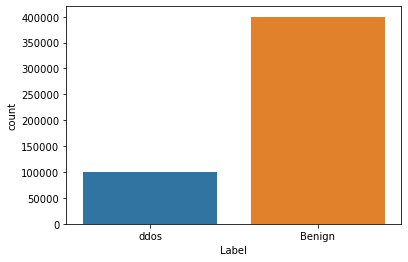

In [9]:
sns.countplot(df['Label']);

## Encoding the target variable

In [10]:
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
df.head()

,Fwd Pkt Len Mean,Fwd Seg Size Avg,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Seg Size Min,Label,SourceIP_1,SourceIP_2,SourceIP_3,SourceIP_4,DestinationIP_1,DestinationIP_2,DestinationIP_3,DestinationIP_4
13318,0.000000,0.000000,-1,17520,0,1,192,168,1,104,203,73,24,75
21539,45.500000,45.500000,-1,5840,0,1,192,168,1,104,203,73,24,75
87259,0.000000,0.000000,-1,17520,0,1,192,168,1,104,203,73,24,75
61071,0.000000,0.000000,-1,17520,0,1,192,168,1,104,203,73,24,75
5143,39.333333,39.333333,-1,5840,0,1,192,168,1,104,203,73,24,75


## Performing Random Undersampling

Since we have over 200K data points for the minority class, random undersampling is performed to get a balanced dataset.

In [11]:
X = df.drop('Label' , axis = 1)
y = df['Label']
RUS = RandomUnderSampler(random_state=42)
X_rus, y_rus = RUS.fit_resample(X,y)

## Splitting the dataset

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Finding our Base Model

In [25]:
models = {"Logistic Regression": LogisticRegression(), "Random Forest": RandomForestClassifier(),
         "KNN": KNeighborsClassifier(), "AdaBoost": AdaBoostClassifier()}

cv = KFold(n_splits=10)

def fit_and_score(models, X_train, X_test, y_train, y_test):
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
        model_scores[name] = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])# model.score(X_test, y_test)
    return model_scores

In [26]:
model_scores = fit_and_score(models, X_train, X_test, y_train, y_test)
model_scores

C:\Users\kedar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.9904716509939988,
 'Random Forest': 0.9999999856560075,
 'KNN': 0.9998091214573287,
 'AdaBoost': 0.9999991923228831}

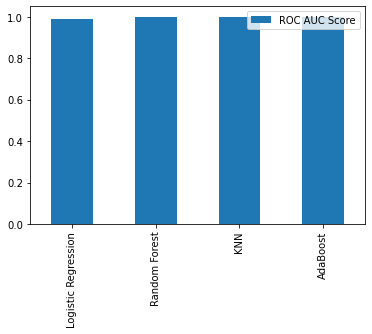

In [27]:
model_compare = pd.DataFrame(model_scores, index=['ROC AUC Score'])
model_compare.T.plot.bar();

We observe very good ROC AUC Score with all models. I went ahead and used the AdaBoost Classifier. 

## Training an AdaBoost Classifier

In [28]:
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9998266666666666

## Evaluating a model

C:\Users\kedar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


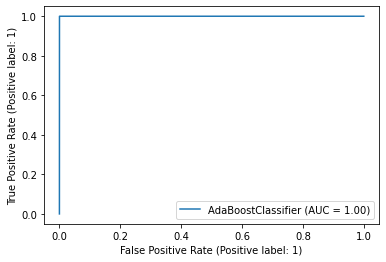

In [29]:
plot_roc_curve(clf, X_test, y_test)

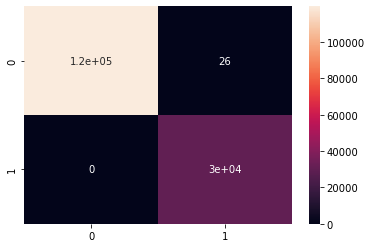

In [30]:
y_preds = clf.predict(X_test)
conf_mat = confusion_matrix(y_test, y_preds)
sns.heatmap(conf_mat, annot=True);

In [31]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    119719
           1       1.00      1.00      1.00     30281

    accuracy                           1.00    150000
   macro avg       1.00      1.00      1.00    150000
weighted avg       1.00      1.00      1.00    150000



In [32]:
y_score = clf.decision_function(X_test)
average_precision = average_precision_score(y_test, y_score)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))

Average precision-recall score: 1.00


C:\Users\kedar\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Precision-Recall curve: AP=1.00')

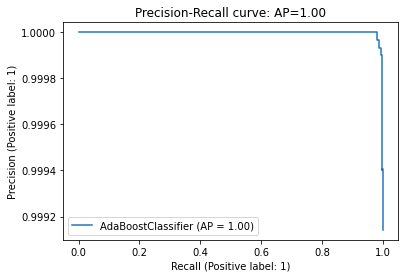

In [33]:
disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))